# Generative AI for Retrieval Augmented Generation of PDF documents

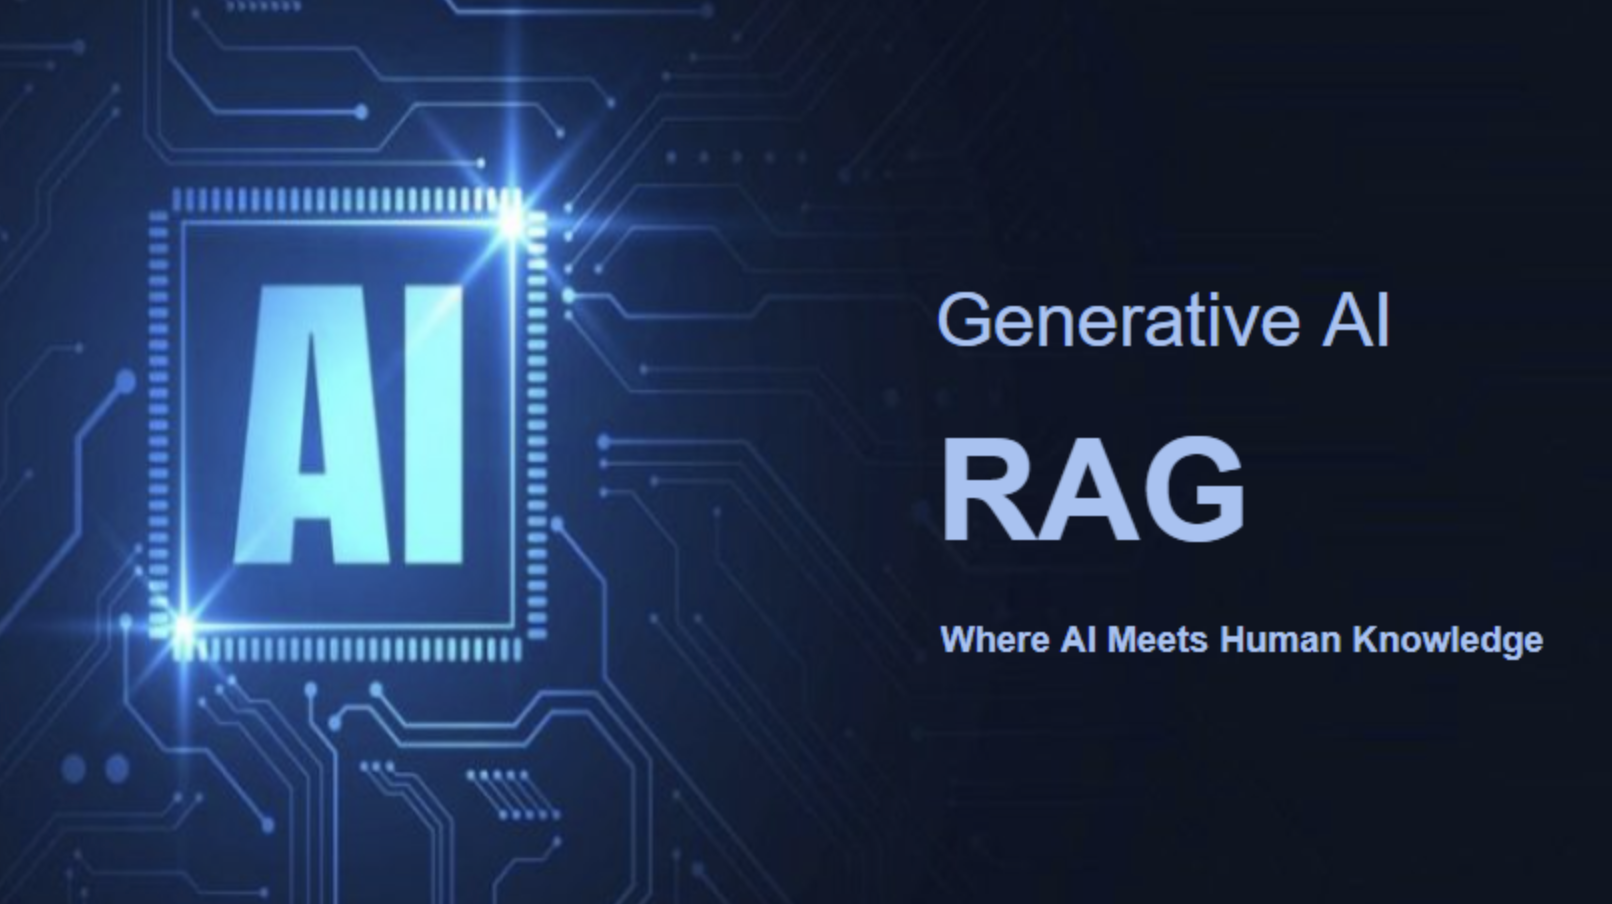

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------

## Content

In this module we will be looking at Generative AI models, which can leveraged to summarize and translate PDF documents. We will be using the audit report, carried out by PWC for the IMF's 2022 financials as an example. This example is easily translatable to any pdf document or set of documents and will be followed by an interactive, practical study of some of the key concepts underlying modern developments in generative AI.

## Defining our target

Summarizing and Translating the raw text embbeded in PDFs

Models: BART, Glove, Word2Vec, Google Translate (API)

Note: The 2 uses cases covered in this module include summarizing text rendered in English and translating text from one language to another

## Importing libraries

Firstly let us import some libraries that are already part of this Jupyter Notebook Environment and are required for this module

In [9]:
from time import time # Required to calculate the time taken to execute blocks of code. This is especially important since we will be working with Large Language Models, which in the absence of GPU’s have a significant runtime
import torch # This imports the PyTorch library, which along with Keras and TensorFlow are the three main libraries that serve as a standard for deploying deep learning models

## Importing libraries

Rather than importing the whole library, which has computational costs, we can import only the tools we need for our specific use cases. In the next step of code we will import the tokenizers and respective summarization models for BART and GPT-2. These models can be found under the transformers library

In [11]:
from transformers import BartTokenizer, BartForConditionalGeneration # The from statement defines which libraries we are accessing. The import statement defines the models/tools we are importing. 
from transformers import GPT2Tokenizer, GPT2LMHeadModel # The comma after import allows us to load multiple models/tools from a library simultaneously

## Extracting the raw text from a PDF

As a primer/example we will be analyzing the audit of the IMF carried out by Price Waterhouse Coopers (PWC), which is stored in the PDF format. Please open the PDF file so that you can easily refer to it.
Firstly, we will open and read this document and determine the number of pages it contains.

In [12]:
import PyPDF2
pdfFileObject = open("2022-financial-statements.pdf", 'rb') 
pdfReader = PyPDF2.PdfReader(pdfFileObject) 
total_pages = len(pdfReader.pages)
total_pages

138

The output shows us that the pdf contains 138 pages

Next, let us focus on pages 8-10, which contains a statement from PWC to the Board of Governors of the IMF regarding their basis/opinon of the IMF’s financials. Firstly, we will extract the raw text from these three pages.

In [13]:
raw_text = ""

for i in range(7,10): #python indexing starts from 0, this is an important point. Whenever you want to look at page 1 from PyPDF the index for it will be 0
    print('Extracting Text from Page:'+str(i+1))
    pageObject = pdfReader.pages[i]
    page_txt = pageObject.extract_text()
    raw_text += page_txt

Extracting Text from Page:8
Extracting Text from Page:9
Extracting Text from Page:10


The raw text is stored and can be accessed using the raw_text variable we created. Let’s take a look at what the raw extracted text for these 3 pages looks like

In [14]:
raw_text

' \n \nPricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001  \nT: (202) 414 1000, www.pwc.com/us  \n \n \nReport of Independent Auditors  \n \nTo the  Board of Governors of the International Monetary Fund  \n \nOpinion  \n \nWe have audited the accompanying financial statements of the General Department of the International \nMonetary Fund (the “Department”), which comprise the  statements of financial position as of April 30, \n2022 and 2021, and the related statements of income, of comprehensive income, of changes in reserves, \nretained earnings, and resources, and of cash flows for the years then ended , including the related notes \n(collectively referred to as the “financial statements”).  \n \nIn our opinion, the accompanying financial statements present fairly, in all material respects, the financial \nposition of the Department as of April 30, 2022 and 2021, and the results of its operations and its cash \nflows for the years then ended in accordance with I


The text is stored as python string (str) object. We can check the type of any variable by using the type method

In [15]:
type(raw_text)

str

You will also observe that the string which stores are raw text has special characters such as “\n”. These special characters indicate new lines in the original text or other formatting code. However, we can parse, tokenize and summarize all the text within these three pages while ignoring this formatting code and other special characters

## Summariziation using BART 

As our next exercise let us tokenize and then summarize the 3 pages we have been looking using the BART model


### Summarizing text only pages

In [16]:
bart_summary = ""

for i in range(7,10):
    t0 = time()
    print ("----------------------------------------------------------------------------------------")
    print('Summarizing Page:'+str(i+1))
    pageObject = pdfReader.pages[i]
    page_txt = pageObject.extract_text()
    bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    inputs = bart_tokenizer.batch_encode_plus([page_txt], return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = bart.generate(inputs['input_ids'], early_stopping=True)
    page_summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    bart_summary += page_summary
    t1 = time() - t0
    print("Time Taken to Summarize Page: " + str(t1))

----------------------------------------------------------------------------------------
Summarizing Page:8
Time Taken to Summarize Page: 24.885271072387695
----------------------------------------------------------------------------------------
Summarizing Page:9
Time Taken to Summarize Page: 29.001285791397095
----------------------------------------------------------------------------------------
Summarizing Page:10
Time Taken to Summarize Page: 16.405396938323975


In [17]:
bart_summary

'We have audited the accompanying financial statements of the General Department of the International Monetary Fund (the “Department”), which comprise the statements of financial position as of April 30, 2022 and 2021. We believe that the audit evidence we have obtained is sufficient and appropriate to provide a basis for our audit opinion.Auditors’ objectives are to obtain reasonable assurance about whether the financial statements as a whole are free from material misstatement, whether due to fraud or error. Reasonable assurance is a high l evel of assurance but is not absolute assurance and is not a guarantee that an audit conducted in accordance with US GAAS and ISAs will always detect a materialmisstatement when it exists.The supplemental schedules are fairly stated, in all material respects, in relation to the fina ncial statements taken as a whole. We also subjected the information to the applicable procedures required by ISAs. In our opinion, the supplemental schedule is fair a

It is important to note that running Deep Learning Models (including LLMs) such as BART incur costs. The costs are in computation/runtime and increase not linearly, but quadratically with the size of the input. Thus, access to GPUs and a distributed/parallel computing infrastructure (via cloud or in-house servers) can significantly enhance performance and are critical to the long-term viability of many AI solutions

We can clearly see from the 3 pages we tried to summarize, using BART, and 16GB of memory and 4 CPUs still takes around over 25 seconds a page. We can access the BART summary using the bart_summary variable where we have it stored


--------------------------
As you can observe, if you read the text in the 3 pages and the summary, the summarizer does a good job of succinctly identifying and generating text that contains the main points outlined in these 3 pages. 

### BART summarizer on pages that contains tables

The next question you might ask is how this pipeline of using PyPDF to extract the raw text and BART for summarization work if a page contains tables. Let us check the results by looking at page 11 of the PDF which contains information stored only in tables.

In [18]:
pageObject_2 = pdfReader.pages[10] # remember python indexing starts from 0 so page 11 is indexed as page 10
page_txt_2 = pageObject_2.extract_text()
page_txt_2

' \nI. General Department  \n \n 7 Statements of Financial Position at April 30, 2022, and 2021 \n(in millions of SDRs)  \n Note  2022   2021  \nAssets     \nUsable currencies   292,280  297,217 \nOther currencies   69,407  71,651 \nCredit outstanding  5 93,031  89,788 \n    Total currencies    454,718  458,656 \nSDR holdings  6 22,270  22,203 \nInvestments 7 25,418  23,032 \nGold holdings  9 3,167  3,167 \nProperty, plant and equipment and intangible assets 10 551  555 \nNet assets under retirement benefit plans 11 1,375  — \nOther assets  12 911  706 \nTotal assets  508,410  508,319 \nLiabilities     \nSpecial Contingent Account  13 —  1,066 \nBorrowings  14 2,615  5,138 \nQuota subscriptions  15 476,272  475,808 \nNet liabilities under retirement benefit plans  11 127  205 \nOther liabilities 12 970  761 \nTotal liabilities  479,984  482,978 \nReserves of the General Resources Account 16 26,524  23,350 \nRetained earnings of the Investment Account  1,902  1,991 \nResources of the Sp

-------------
As one can see the raw text (even from tables) is still extracted with a lot of formatting syntax. If you want to learn how to extract this type of tabular data efficaciously and store it for further analysis, please look at the module M2_3 which covers liberating data from PDFs via table extraction using computer vision and OCR. For this module let us see what the output of the BART summarizer is for this page

In [19]:
inputs = bart_tokenizer.batch_encode_plus([page_txt_2], return_tensors='pt', max_length=1024, truncation=True)
summary_ids = bart.generate(inputs['input_ids'], early_stopping=True)
page_summary_2 = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [20]:
page_summary_2

'These financial statements were signed by the Managing Director and the Director of Finance on June 24, 2022. The accompanying notes are an integral part of these financial statements. The financial statements are in millions of SDRs and are published in the form of a statement of financial position.'

As you can see the BART model has mainly ignored the text that was in the tables and only outputs text formatted in a way it has been trained to understand. Module M2_3 is the preferred approach to extract information from a PDF that is housed withing tables while this module covers the other scenario of summarizing large bodies of text held outside of tables. Thus, they are complimentary and can be used simultaneously to extract and store structured data in PDFs and quickly summarize and understand the unstructured data accompanying it

### Summarizing a whole document

We can now summarize the whole document though the runtime will be significant due to the PDF containing 138 pages. You may uncomment the following code to execute this, but **WARNING: you will have to wait over 35 mins** for the full summary to be compiled.

This re-illustrates the point that deploying LLMs in a production environment cannot be effectively done without access to GPU’s and parallel computing, which is one of the key drawbacks of large deep learning models. Thankfully, GPU access and architecture is becoming increasingly cheaper and available via the cloud of on premise from vendors such as Nvidia. 

In [ ]:
# bart_full_summary = ""

# for i in range(1,total_pages):
#     t0 = time()
#     print ("----------------------------------------------------------------------------------------")
#     print('Summarizing Page:'+str(i+1))
#     pageObject = pdfReader.pages[i]
#     page_txt = pageObject.extract_text()
#     bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
#     bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
#     inputs = bart_tokenizer.batch_encode_plus([page_txt], return_tensors='pt', max_length=1024, truncation=True)
#     summary_ids = bart.generate(inputs['input_ids'], early_stopping=True)
#     page_summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#     bart_full_summary += page_summary
#     t1 = time() - t0
#     print("Time Taken to Summarize Page: " + str(t1))

## Machine translation of text across multiple languages

In the next part of this module, we will be using the Google Translator model, which can accessed the deep translator package and is able to translate text from one language to another. First, we will import the required library

### Supported Languages

We can use the google translator translate any text between the supported languages. The languages that are supported are listed here along with their corresponding codes:

LANGUAGES = {
    'af': 'afrikaans',
    'sq': 'albanian',
    'am': 'amharic',
    'ar': 'arabic',
    'hy': 'armenian',
    'az': 'azerbaijani',
    'eu': 'basque',
    'be': 'belarusian',
    'bn': 'bengali',
    'bs': 'bosnian',
    'bg': 'bulgarian',
    'ca': 'catalan',
    'ceb': 'cebuano',
    'ny': 'chichewa',
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'co': 'corsican',
    'hr': 'croatian',
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'eo': 'esperanto',
    'et': 'estonian',
    'tl': 'filipino',
    'fi': 'finnish',
    'fr': 'french',
    'fy': 'frisian',
    'gl': 'galician',
    'ka': 'georgian',
    'de': 'german',
    'el': 'greek',
    'gu': 'gujarati',
    'ht': 'haitian creole',
    'ha': 'hausa',
    'haw': 'hawaiian',
    'iw': 'hebrew',
    'he': 'hebrew',
    'hi': 'hindi',
    'hmn': 'hmong',
    'hu': 'hungarian',
    'is': 'icelandic',
    'ig': 'igbo',
    'id': 'indonesian',
    'ga': 'irish',
    'it': 'italian',
    'ja': 'japanese',
    'jw': 'javanese',
    'kn': 'kannada',
    'kk': 'kazakh',
    'km': 'khmer',
    'ko': 'korean',
    'ku': 'kurdish (kurmanji)',
    'ky': 'kyrgyz',
    'lo': 'lao',
    'la': 'latin',
    'lv': 'latvian',
    'lt': 'lithuanian',
    'lb': 'luxembourgish',
    'mk': 'macedonian',
    'mg': 'malagasy',
    'ms': 'malay',
    'ml': 'malayalam',
    'mt': 'maltese',
    'mi': 'maori',
    'mr': 'marathi',
    'mn': 'mongolian',
    'my': 'myanmar (burmese)',
    'ne': 'nepali',
    'no': 'norwegian',
    'or': 'odia',
    'ps': 'pashto',
    'fa': 'persian',
    'pl': 'polish',
    'pt': 'portuguese',
    'pa': 'punjabi',
    'ro': 'romanian',
    'ru': 'russian',
    'sm': 'samoan',
    'gd': 'scots gaelic',
    'sr': 'serbian',
    'st': 'sesotho',
    'sn': 'shona',
    'sd': 'sindhi',
    'si': 'sinhala',
    'sk': 'slovak',
    'sl': 'slovenian',
    'so': 'somali',
    'es': 'spanish',
    'su': 'sundanese',
    'sw': 'swahili',
    'sv': 'swedish',
    'tg': 'tajik',
    'ta': 'tamil',
    'te': 'telugu',
    'th': 'thai',
    'tr': 'turkish',
    'uk': 'ukrainian',
    'ur': 'urdu',
    'ug': 'uyghur',
    'uz': 'uzbek',
    'vi': 'vietnamese',
    'cy': 'welsh',
    'xh': 'xhosa',
    'yi': 'yiddish',
    'yo': 'yoruba',
    'zu': 'zulu',

In the above text the codes for a language are displated first along with which language they refer to In the above text the codes for a language are displayed first along with which language they refer to. So for example ‘af’ refers to 'afrikaans'

### Translating a string object

Firstly let us see how a simple string object, which is how we have been extracting, saving and summarizing our text can be translated from English to Spanish using our translator

In [23]:
from deep_translator import GoogleTranslator
translation = GoogleTranslator(source='en', target='es').translate("hello world") 
translation

'Hola Mundo'

In this example we saved the translation as a variable named translation, the source and target set the language the input string is in and which language to translate it to. The output is a new translated string. Also please note that setting the source to source = 'auto', results in the model automatically inferring what the input language is, which is useful in cases where we may have a lot of different text data in multiple languages and want to translate all of it to one language. Below is an example of how to use this functionality

In [32]:
from deep_translator import GoogleTranslator
translation = GoogleTranslator(source='auto', target='es').translate("hello world") 
translation

'Hola Mundo'

### Translating a BART summary

Next let us translate the summary we extracted using BART of the pages regarding the opinion of PWC in the Audit PDF

In [24]:
translation = GoogleTranslator(source='en', target='es').translate(bart_summary) 
translation

'Hemos auditado los estados financieros adjuntos del Departamento General del Fondo Monetario Internacional (el “Departamento”), que comprenden los estados de situación financiera al 30 de abril de 2022 y 2021. Creemos que la evidencia de auditoría que hemos obtenido es suficiente. y apropiado para proporcionar una base para nuestra opinión de auditoría. Los objetivos de los auditores son obtener una seguridad razonable sobre si los estados financieros en su conjunto están libres de errores materiales, ya sea debido a fraude o error. Seguridad razonable es un alto nivel de seguridad, pero no es una seguridad absoluta ni garantiza que una auditoría realizada de conformidad con los GAAS y las ISA de EE. UU. siempre detecte una incorrección material cuando exista. Los anexos complementarios están expresados \u200b\u200bde manera justa, en todos los aspectos importantes. , en relación con los estados financieros tomados en su conjunto. También sometimos la información a los procedimientos 

As you can see, with a few simple lines of code we can easily translate text from one language to another

### Translating the raw extracted text from PDFs

The above examples work fine if the input string is clean, as the output for example from the BART summarizer. However, how does the translator perform if the text has not been through the summarizer? Let us test this on page 8 of the report. First let us extract the raw text.

In [25]:
pageObject = pdfReader.pages[7]
page_txt = pageObject.extract_text()
page_txt

' \n \nPricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001  \nT: (202) 414 1000, www.pwc.com/us  \n \n \nReport of Independent Auditors  \n \nTo the  Board of Governors of the International Monetary Fund  \n \nOpinion  \n \nWe have audited the accompanying financial statements of the General Department of the International \nMonetary Fund (the “Department”), which comprise the  statements of financial position as of April 30, \n2022 and 2021, and the related statements of income, of comprehensive income, of changes in reserves, \nretained earnings, and resources, and of cash flows for the years then ended , including the related notes \n(collectively referred to as the “financial statements”).  \n \nIn our opinion, the accompanying financial statements present fairly, in all material respects, the financial \nposition of the Department as of April 30, 2022 and 2021, and the results of its operations and its cash \nflows for the years then ended in accordance with I

Next lets run the translator on this text and look at the output

In [26]:
translation = GoogleTranslator(source='en', target='es').translate(page_txt) 
translation

'PricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001\nTeléfono: (202) 414 1000, www.pwc.com/us\n \n \nInforme de Auditores Independientes\n \nA la Junta de Gobernadores del Fondo Monetario Internacional\n \nOpinión\n \nHemos auditado los estados financieros adjuntos del Departamento General del Instituto Internacional\nFondo Monetario (el “Departamento”), que comprenden los estados de situación financiera al 30 de abril de\n2022 y 2021, y los correspondientes estados de resultados, de resultado integral, de cambios en reservas,\nganancias retenidas, recursos y flujos de efectivo por los años terminados en esas fechas, incluidas las notas relacionadas\n(denominados colectivamente “estados financieros”).\n \nEn nuestra opinión, los estados financieros adjuntos presentan razonablemente, en todos los aspectos importantes, la situación financiera.\nposición del Departamento al 30 de abril de 2022 y 2021, y los resultados de sus operaciones y su caja\nflujos para los año

As you can observe the translator, unlike BART, doesn’t ignore the special characters in the text, specifically the ‘\n’ character, which indicates the start of a new line. In order to account for this, we need to do some cleaning of the raw text before inputting it into the translator. An easy way to do this is to split the raw text string into multiple different strings

In [29]:
clean_strings = page_txt.split('\n')
clean_strings

[' ',
 ' ',
 'PricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001  ',
 'T: (202) 414 1000, www.pwc.com/us  ',
 ' ',
 ' ',
 'Report of Independent Auditors  ',
 ' ',
 'To the  Board of Governors of the International Monetary Fund  ',
 ' ',
 'Opinion  ',
 ' ',
 'We have audited the accompanying financial statements of the General Department of the International ',
 'Monetary Fund (the “Department”), which comprise the  statements of financial position as of April 30, ',
 '2022 and 2021, and the related statements of income, of comprehensive income, of changes in reserves, ',
 'retained earnings, and resources, and of cash flows for the years then ended , including the related notes ',
 '(collectively referred to as the “financial statements”).  ',
 ' ',
 'In our opinion, the accompanying financial statements present fairly, in all material respects, the financial ',
 'position of the Department as of April 30, 2022 and 2021, and the results of its operations and its 

Then we can simply pass each of the multiple strings through the translator one by one and save the outputs using a for loop

In [30]:
clean_translation = []
for i in range(len(clean_strings)):
    translation = GoogleTranslator(source='en', target='es').translate(clean_strings[i]) 
    clean_translation.append(translation)
clean_translation

['',
 '',
 'PricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001',
 'Teléfono: (202) 414 1000, www.pwc.com/us',
 '',
 '',
 'Informe de Auditores Independientes',
 '',
 'A la Junta de Gobernadores del Fondo Monetario Internacional',
 '',
 'Opinión',
 '',
 'Hemos auditado los estados financieros adjuntos del Departamento General del Instituto Internacional',
 'Fondo Monetario (el “Departamento”), que comprenden los estados de situación financiera al 30 de abril de',
 '2022 y 2021, y los correspondientes estados de resultados, de resultado integral, de cambios en reservas,',
 'ganancias retenidas, recursos y flujos de efectivo por los años terminados en esas fechas, incluidas las notas relacionadas',
 '(denominados colectivamente “estados financieros”).',
 '',
 'En nuestra opinión, los estados financieros adjuntos presentan razonablemente, en todos los aspectos importantes, la situación financiera.',
 'posición del Departamento al 30 de abril de 2022 y 2021, y los resu

Alternatively we can save the translation as a one long string, the same way we have been storing our summaries

In [31]:
clean_translation = ''
for i in range(len(clean_strings)):
    translation = GoogleTranslator(source='en', target='es').translate(clean_strings[i]) 
    clean_translation += translation
clean_translation

'PricewaterhouseCoopers LLP, 655 New York Avenue NW, Washington, DC 20001Teléfono: (202) 414 1000, www.pwc.com/usInforme de Auditores IndependientesA la Junta de Gobernadores del Fondo Monetario InternacionalOpiniónHemos auditado los estados financieros adjuntos del Departamento General del Instituto InternacionalFondo Monetario (el “Departamento”), que comprenden los estados de situación financiera al 30 de abril de2022 y 2021, y los correspondientes estados de resultados, de resultado integral, de cambios en reservas,ganancias retenidas, recursos y flujos de efectivo por los años terminados en esas fechas, incluidas las notas relacionadas(denominados colectivamente “estados financieros”).En nuestra opinión, los estados financieros adjuntos presentan razonablemente, en todos los aspectos importantes, la situación financiera.posición del Departamento al 30 de abril de 2022 y 2021, y los resultados de sus operaciones y su cajaflujos para los años terminados en esa fecha de acuerdo con l

## Preparing for next steps¶

In this module we cover how generative AI can be used to summarize and translate the raw text held in PDFs such as financial reports. We demonstrated how easy it is to install, import and execute these models with only a few lines of code.

It must be noted that the performance of these Large Language Models, to be feasible for a production environment require GPU’s and distributed/parallel computing. The good news in this regard is that GPUs have become increasingly cheaper and can be accessed via cloud services or installed on premises for sensitive data. 


## Preparing for next steps¶

In this module we cover how generative AI can be used to summarize and translate the raw text held in PDFs such as financial reports. We demonstrated how easy it is to install, import and execute these models with only a few lines of code.

It must be noted that the performance of these Large Language Models, to be feasible for a production environment require GPU’s and distributed/parallel computing. The good news in this regard is that GPUs have become increasingly cheaper and can be accessed via cloud services or installed on premises for sensitive data.

As next steps you might consider uploading your own PDF, perhaps written in a different language and use the translation and summarization models on them. Alternatively, you may try combining the summarization part of this module with module 2_3, which focuses on extracting, in a structured way the data stored in tables within PDFs, and analyzing whether automated summarization of the text part of the PDF delivers new insights or information not contained within the tables.